## Notebook setup

In [3]:
# Standard libraries
import os
import sys

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from jupyterthemes import jtplot

# Numerical libraries
import numpy as np
import pandas as pd
import patsy as pt
import pymc3 as pm
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from theano import tensor as T

# Internal libraries
sys.path.append('../../src')
from lib.reconstruction.bayes.preprocessing.pivots import (load_tidy, 
                                                           compute_extra_tidy, 
                                                           compute_per_subject_pivot, 
                                                           compute_per_trial_pivot)
from lib.reconstruction.features import count_all_features

In [4]:
# Notebook configuration
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 100)
# os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32'

sns.set_context('paper')
sns.set_style('white')

colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)

%matplotlib inline

## Load data

In [5]:
tidy_df, board_set_df = load_tidy('../../etc/reconstruction/tidy_data.csv')

# One position was duplicated between real/fake positions; drop it from data
valid_ids = tidy_df.pivot_table(index='Position ID', values='Subject ID', aggfunc=len)
valid_ids = valid_ids.loc[valid_ids['Subject ID'] == 38]
valid_ids = valid_ids.index.tolist()
tidy_df = tidy_df.loc[tidy_df['Position ID'].isin(valid_ids)]
board_set_df = board_set_df.loc[valid_ids]
board_set_df.sort_index(inplace=True)
board_set_df.reset_index(inplace=True, drop=True)

upids = tidy_df.sort_values('Position ID')['Position ID'].unique()
pid_map = dict(zip(upids, np.arange(0, len(upids), 1, dtype=int)))
tidy_df['Position ID'] = tidy_df['Position ID'].map(pid_map)

extra_tidy_df = compute_extra_tidy(tidy_df)
per_trial_df = compute_per_trial_pivot(extra_tidy_df)
per_subject_df = compute_per_subject_pivot(per_trial_df)

In [6]:
# Add features
all_features = tidy_df.apply(count_all_features, axis=1)
feature_names = list(all_features.iloc[0].keys())

for fn in feature_names:
    extra_tidy_df[f'feature_{fn}'] = np.concatenate(all_features.map(lambda x: x[fn]).values)
    
extra_tidy_df['same'] = extra_tidy_df['same'].astype(float)
extra_tidy_df['opposite'] = extra_tidy_df['opposite'].astype(float)

### Data preprocessing

In [7]:
num_position_levels = len(extra_tidy_df.position_type.unique())
num_condition_levels = len(extra_tidy_df.condition_indicator.unique())
num_interaction_levels = num_position_levels * num_condition_levels
num_subjects = len(extra_tidy_df.usubject.unique())

In [8]:
extra_tidy_df['n_pieces'] = extra_tidy_df.position_id.map(board_set_df['Num Pieces'])

In [9]:
formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) * C(position_type, Sum)'
# formula = 'errors_2 ~ C(condition_indicator, Sum) * C(position_type, Sum)'
exogenous_df, endogenous_df = pt.dmatrices(formula, per_trial_df, 
                                           return_type='dataframe', 
                                           NA_action='raise')
endogenous_df = endogenous_df.astype(int)

In [10]:
extra_tidy_df['successes_2'] = extra_tidy_df['occupied'] - extra_tidy_df['errors_2']
# formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) * C(position_type, Sum)'
formula = 'errors_2 ~ C(condition_indicator, Sum) * C(position_type, Sum) + n_pieces + same + opposite'

# exogenous_df, endogenous_df = pt.dmatrices(formula, extra_tidy_df, 
#                                            return_type='dataframe', 
#                                            NA_action='raise')
# endogenous_df = endogenous_df.astype(int)

sm_model = sm.Logit.from_formula(formula, extra_tidy_df)
result = sm_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.286245
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               errors_2   No. Observations:               128592
Model:                          Logit   Df Residuals:                   128585
Method:                           MLE   Df Model:                            6
Date:                Fri, 18 Oct 2019   Pseudo R-squ.:                  0.1416
Time:                        20:47:25   Log-Likelihood:                -36809.
converged:                       True   LL-Null:                       -42882.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -4.6367      0.067    -69.351      0.000      -4.768      -4.506
C(condition_indicator, Sum)[S.0]                                0.0738      0.010      7.480      0.000       0.054       0.093
C(position_type, Sum)[S.0]                                      0.3704      0.010     36.353      0.000       0.350       0.390
C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]     0.0045      0.010      0.456      0.649      -0.015       0.024
n_pieces                                                        0.1076      0.004     24.385      0.000       0.099       0.116
same                                                            0.4505      0.063      7.163      0.000       0.327       0.574
opposite                                                        4.2410      0.050     84.942      0.000       4.143       4.339
===============================================================================================================================
"""

In [11]:
exogenous_df, endogenous_df = pt.dmatrices(formula, extra_tidy_df, 
                                           return_type='dataframe', 
                                           NA_action='raise')
endogenous_df = endogenous_df.astype(int)

### Bayesian

In [12]:
extra_tidy_df['same'] = extra_tidy_df['same'].astype(float)
extra_tidy_df['opposite'] = extra_tidy_df['opposite'].astype(float)

formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) + C(position_type, Sum) + '
formula += 'n_pieces + same + opposite + '
formula += ' + '.join(f'feature_{fn}' for fn in feature_names)

df = extra_tidy_df.copy()
df['n_pieces'] = df.n_pieces - df.n_pieces.max() + .5 * (df.n_pieces.max() - df.n_pieces.min())
df['same'] = df.same - .5
df['opposite'] = df.opposite - .5

exogenous_df, endogenous_df = pt.dmatrices(formula, df, 
                                           return_type='dataframe', 
                                           NA_action='raise')

index_cols = ['Intercept', 
              'C(condition_indicator, Sum)[S.0]', 
              'C(position_type, Sum)[S.0]', 
              'C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]']

for c in index_cols:
    if c in endogenous_df.columns:
        endogenous_df[c] = endogenous_df[c].astype(int)
    
endogenous_df

,Intercept,"C(usubject, Sum)[S.0]","C(usubject, Sum)[S.1]","C(usubject, Sum)[S.2]","C(usubject, Sum)[S.3]","C(usubject, Sum)[S.4]","C(usubject, Sum)[S.5]","C(usubject, Sum)[S.6]","C(usubject, Sum)[S.7]","C(usubject, Sum)[S.8]","C(usubject, Sum)[S.9]","C(usubject, Sum)[S.10]","C(usubject, Sum)[S.11]","C(usubject, Sum)[S.12]","C(usubject, Sum)[S.13]","C(usubject, Sum)[S.14]","C(usubject, Sum)[S.15]","C(usubject, Sum)[S.16]","C(usubject, Sum)[S.17]","C(usubject, Sum)[S.18]",...,"C(usubject, Sum)[S.34]","C(usubject, Sum)[S.35]","C(usubject, Sum)[S.36]","C(condition_indicator, Sum)[S.0]","C(position_type, Sum)[S.0]",n_pieces,same,opposite,feature_1100b,feature_1100w,feature_1010b,feature_1010w,feature_1001b,feature_1001w,feature_1110b,feature_1110w,feature_1101b,feature_1101w,feature_1111b,feature_1111w
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1,-1,0.5,-0.5,-0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1,-1,0.5,-0.5,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1,-1,0.5,-0.5,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1,-1,0.5,-0.5,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1,-1,0.5,-0.5,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128587,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1,1,-0.5,-0.5,-0.100000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128588,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1,1,-0.5,-0.5,-0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128589,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1,1,-0.5,-0.5,-0.300000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1,1,-0.5,-0.5,-0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_ = extra_tidy_df.loc[extra_tidy_df['occupied'] == 1]

In [29]:
for k, v in coeff_spec.items():
    print(k, v.values.dtype)

condition uint8
position uint8
n_pieces int64
same float64
opposite float64
features int64
subjects uint8


In [27]:
pd.get_dummies(extra_tidy_df['condition_indicator'], prefix='condition')['condition_1'].values.dtype

dtype('uint8')

In [42]:
np.concatenate([v.values for v in coeff_spec.values()], axis=1)

(51984, 57)

In [ ]:
class Coefficient(object):
    def __init__(self, name, columns, df, dtype=int, categorical=False, share_prior=False):
        assert not (len(columns) == 1 and categorical), "Only one column allowed for categorical"
        
        self.name = name
        self.columns = columns
        self.df = df
        
        self.dtype = dtype
        self.categorical = categorical
        self.share_prior = share_prior
        
        self.data = self._format()
        self.shape = [len(self.data.columns)]
        
    def _format(self):
        if self.categorical:
            data = pd.get_dummies(self.df[self.columns[0]], prefix=self.name)
            
        else:
            data = self.df[self.columns].satype(self.dtype)
            
        return data
        
    def create(self, mu=0):
        if self.share_prior:
            sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
        else:
            sigma = pm.Gamma(f'sigma_{name}', 1.64, .32, shape=self.shape)
        
        a = pm.Normal(f'a_{name}', mu=mu, sigma=sigma, shape=self.shape)
        
        return a
    

coeff_spec = {
    'condition': Coefficient('condition', ['condition_indicator'], categorical=True),
    'position': Coefficient('position', ['position_type'], categorical=True),
    'n_pieces': Coefficient('n_pieces', ['n_pieces'], share_prior=True),
    'same': Coefficient('same', ['same'], dtype=float, share_prior=True),
    'features': Coefficient('features', [c for c in df_.columns if 'feature' in c],
                            share_prior=False),
    'subjects': Coefficient('subjects', ['usubject'], categorical=True)
#               'interaction': ['C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]'],
}

In [84]:
def create_coeff(name, shape, mu=0, share_prior=True):
    if share_prior:
        sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
    else:
        sigma = pm.Gamma(f'sigma_{name}', 1.64, .32, shape=shape)
        
    a = pm.Normal(f'a_{name}', mu=mu, sigma=sigma, shape=shape)
    
    return a


with pm.Model() as logistic_anova:
    # Create intercept coefficient; no prior on variance
    b0 = pm.Normal('intercept', mu=0, sd=1, shape=[1])
    
#     coeffs = {k: create_coeff(k, [len(v['data'].columns)], share_prior=v['share_prior']) 
#               for k, v in coeff_spec.items()}
    coeffs = {k: v.create() for k, v in coeff_spec.items()}
    
    B = T.concatenate([b for _, b in coeffs.items()])
    values = np.concatenate([v['data'].values for v in coeff_spec.values()], axis=1)
    mu = b0 + T.sum(B * values, axis=1)
        
    mu = pm.invlogit(mu)
#     kappa = pm.Gamma('beta_variance', .01, .01)
#     alpha = mu * (kappa - 2) + 1
#     beta = (1 - mu) * (kappa - 2) + 1

#     theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=exogenous_df.shape[0])
    y = pm.Bernoulli('targets', p=mu, observed=df_['errors_2'].values)

In [85]:
with logistic_anova:
    step = pm.NUTS(target_accept=.99, max_treedepth=10)
    trace = pm.sample(1000, step, tune=750, chains=8, cores=8) #, start=start)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [a_subjects, sigma_subjects, a_features, sigma_features, a_opposite, sigma_opposite, a_same, sigma_same, a_n_pieces, sigma_n_pieces, a_position, sigma_position, a_condition, sigma_condition, intercept]
Sampling 8 chains:  95%|█████████▍| 13277/14000 [38:25:05<2:01:22, 10.07s/draws] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



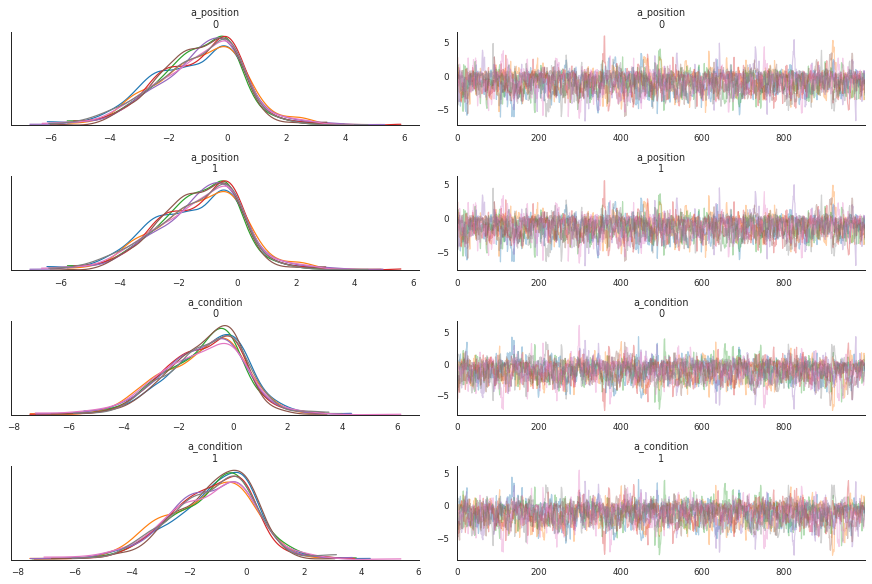

In [86]:
sns.set_style('white')
pm.traceplot(trace, var_names=['a_position', 'a_condition', 'a_num_pieces'])
sns.despine();

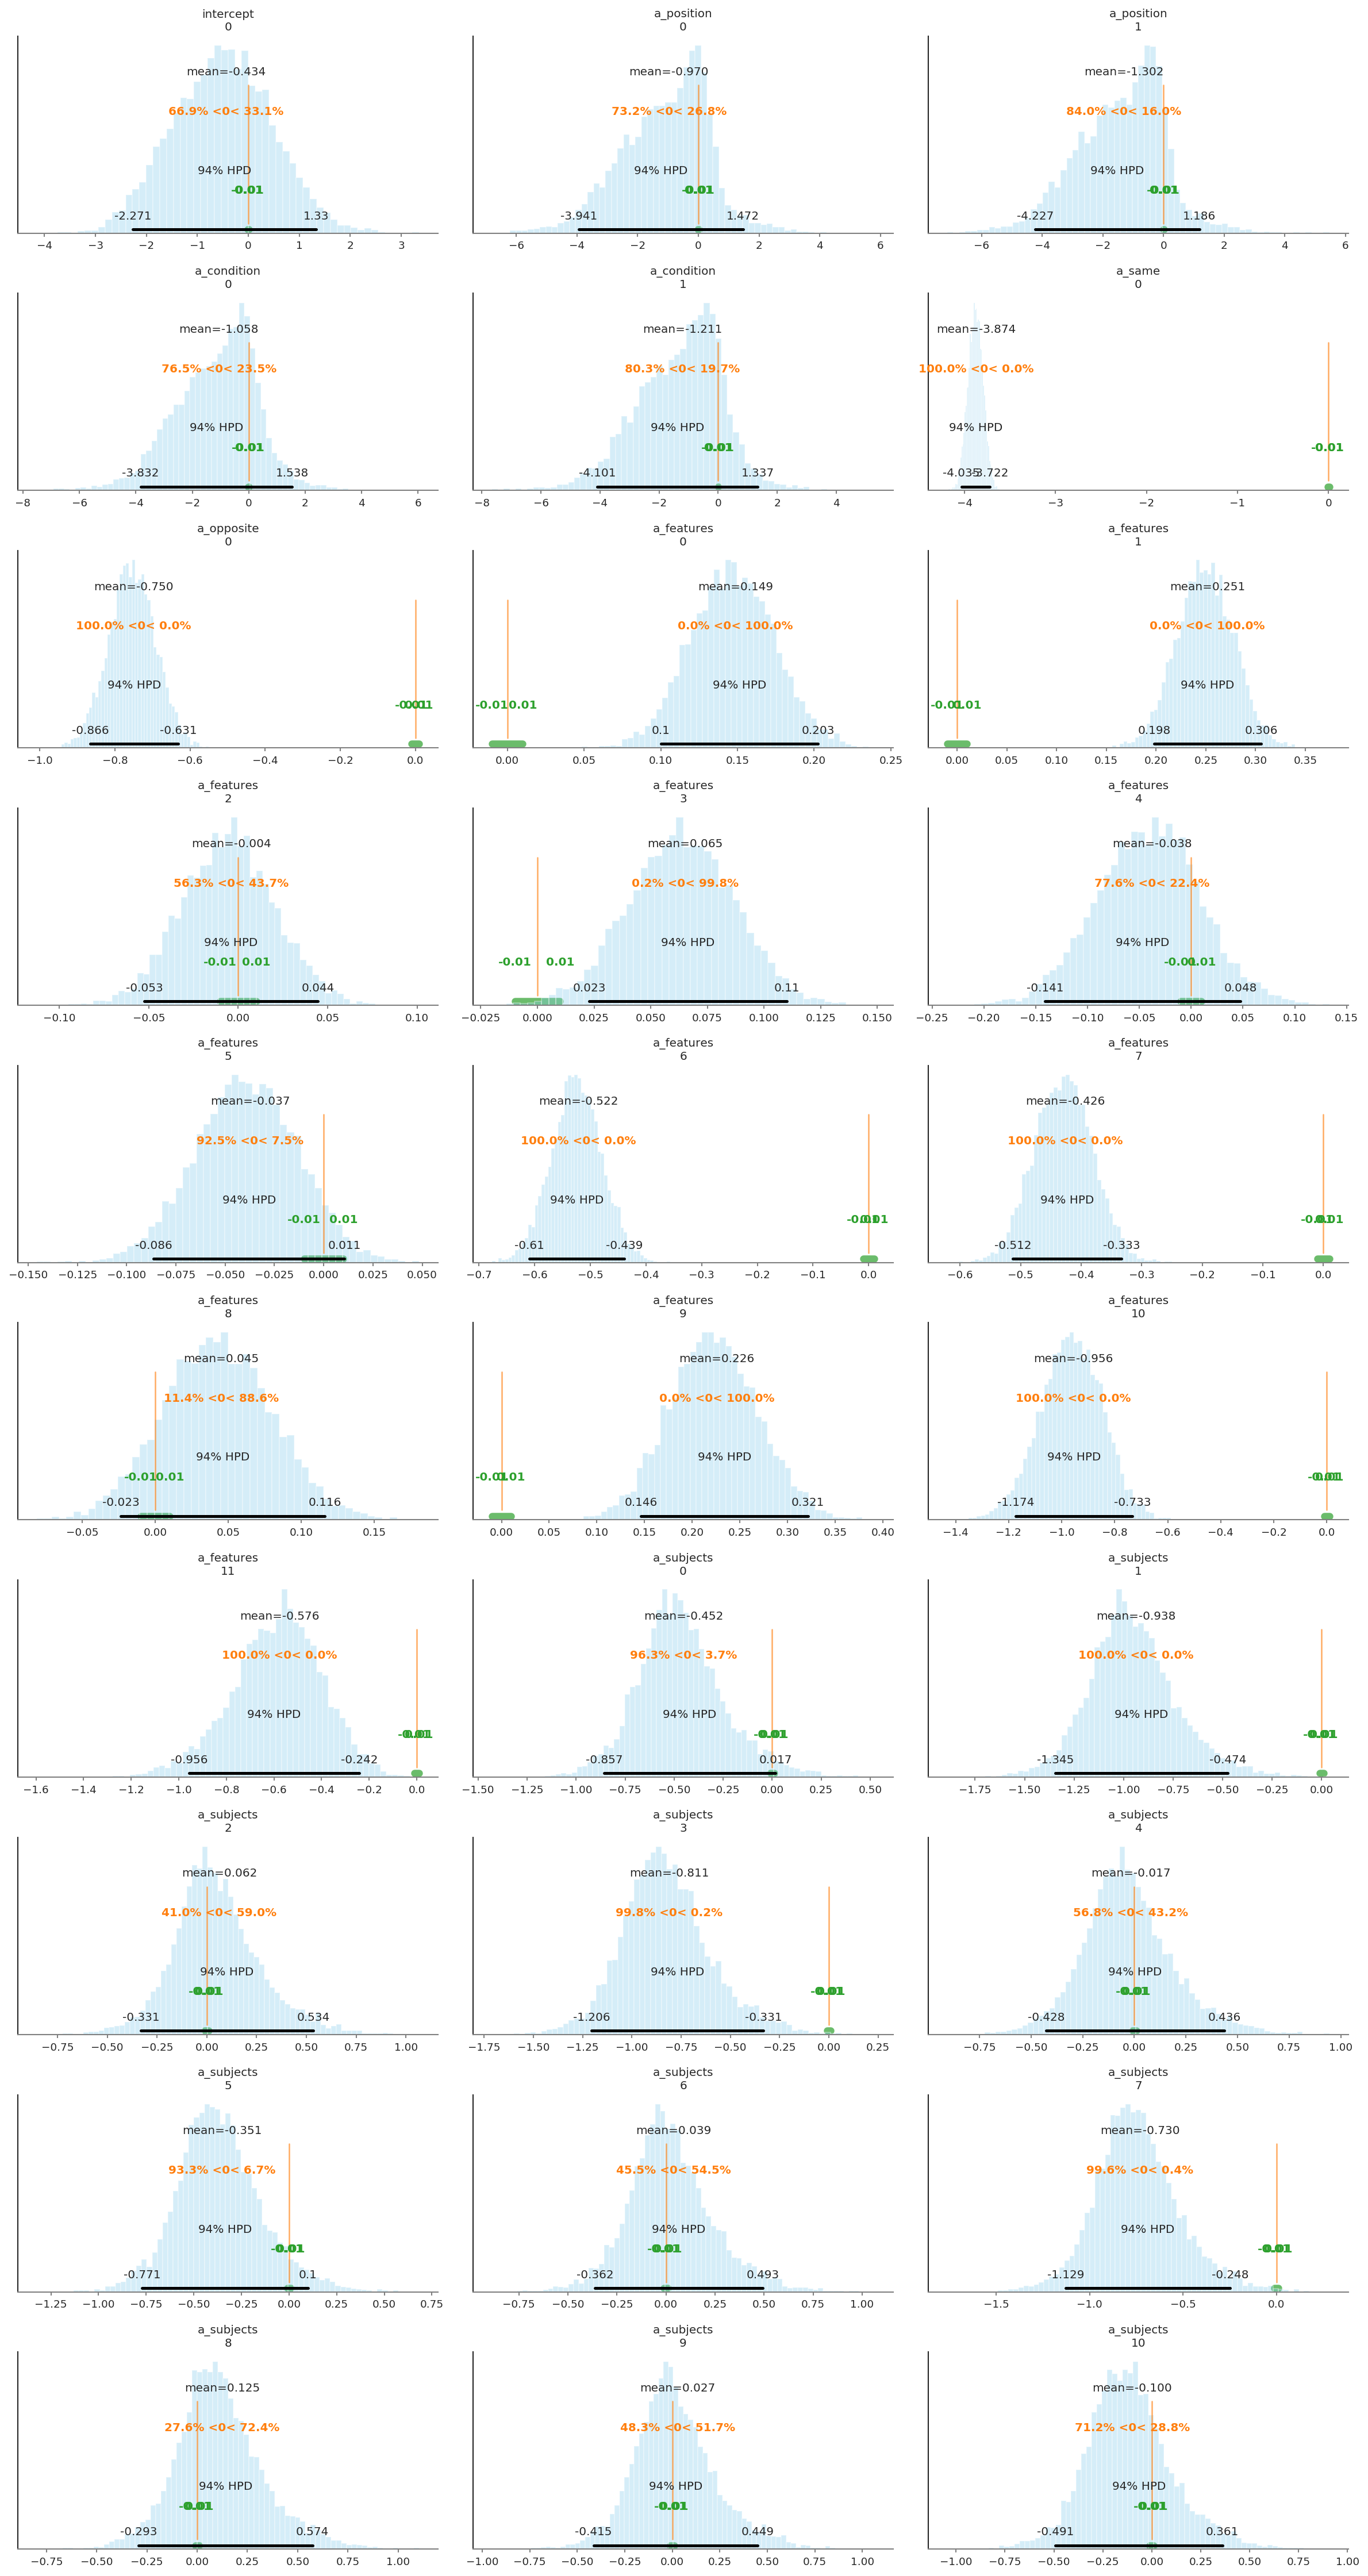

In [87]:
sns.set_style('white')

fig, axes = plt.subplots(10, 3, figsize=(16, 30), dpi=150)

var_names = ['intercept', 'a_position', 'a_condition', 
             'a_num_pieces', 'a_interaction', 'a_same', 
             'a_opposite', 'a_features', 'a_subjects']

# var_names += [f'a_feature_{fn}' for fn in feature_names]

pm.plot_posterior(trace, 
                  var_names=var_names,
                  color='#87ceeb', kind='hist', ax=axes,
                  rope=(-.01, .01), ref_val=0, round_to=3)

sns.despine()
plt.tight_layout();

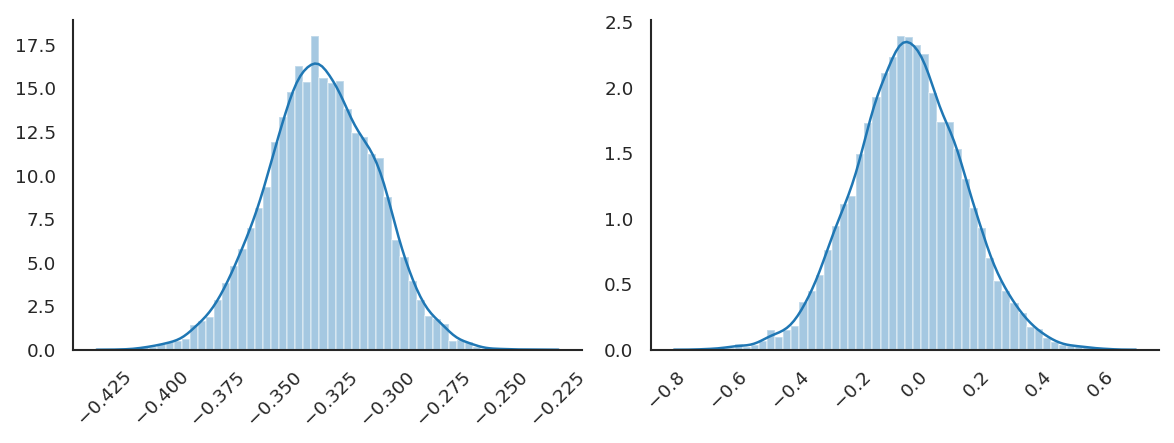

In [81]:
v_subjects = trace['a_subjects']
m_subjects = np.stack([v_subjects[:, :19].mean(), v_subjects[:, 19:].mean()])

v_position = trace['a_position']
v_condition = trace['a_condition']
v_condition -= v_condition.mean(axis=0)
v_condition += m_subjects



fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

sns.distplot(v_position[:, 1] - v_position[:, 0], ax=axes[0])
sns.distplot(v_condition[:, 1] - v_condition[:, 0], ax=axes[1])

plt.setp([ax.get_xticklabels() for ax in axes.flatten()], 
         rotation=45)

sns.despine()
fig.tight_layout();

In [80]:
v_condition.mean(axis=0).shape

(2,)

In [69]:
df_.pivot_table(index='usubject', values='condition_indicator', 
                aggfunc=lambda x: x.values[0],)

,condition_indicator
usubject,
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0


In [64]:
v_subjects.shape

(8000, 38)

In [ ]:
np.exp(.08) / (1 + np.exp(.08))

In [ ]:
formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) + C(position_type, Sum)'

df = per_subject_df

exogenous_df, endogenous_df = pt.dmatrices(formula, df, 
                                           return_type='dataframe', 
                                           NA_action='raise')
endogenous_df = endogenous_df.astype(int)

# def create_coeff(name, shape, mu=None):
#     if mu is None:
#         # Group prior on coefficient variance
#         sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
#         # Group prior on coefficient mean
#         mu = pm.Normal(f'mu_{name}', mu=0, tau=1/sigma**2)
    
#     # Coefficient samples
#     a = pm.Normal(f'a_{name}', mu=mu, sd=.1, shape=shape)
#     return a

def create_coeff(name, shape, mu=0):
#     sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
    sigma = pm.Gamma(f'sigma_{name}', .01, .01)
    a = pm.Normal(f'a_{name}', mu=mu, tau=1/sigma**2, shape=shape)
    return a

with pm.Model() as logistic_anova:
    # Create placeholder lists for PyMC RVs
    sds = []
    coeffs = []

    # Create intercept coefficient; no prior on variance
    b0 = pm.Normal('intercept', mu=0, sd=1, shape=[1])
    b_condition = create_coeff('condition', 1)
    b_position = create_coeff('position', 1)
#     b_interaction = create_coeff('interaction', 1)
    b_subject = create_coeff('subject', endogenous_df.shape[1] - 3)
#     b = T.concatenate([b_subject, b_condition, b_position, b_interaction])
    b = T.concatenate([b_subject, b_condition, b_position])

    # Estimate mean of beta prior as sigmoid
    mu = T.nnet.sigmoid(b0 + T.dot(endogenous_df.values[:, 1:], b))
    kappa = pm.Gamma('beta_variance', .01, .01)
    alpha = mu * (kappa - 2) + 1
    beta = (1 - mu) * (kappa - 2) + 1

    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=exogenous_df.shape[0])
    
    # Likelihood
    y = pm.Binomial('targets', 
                    n=df['occupied'].values,
                    p=theta,
                    observed=exogenous_df['errors_2'].values)
    
    # Contrasts
    
    #   Within-group subject correction
    #     Compute full subject coefficients
    s = T.concatenate([b_subject, -T.sum(b_subject, keepdims=True)])
    #     Reshape to have subject coeffs grouped by condition
    s = s.reshape((2, -1))
    b_condition_0 = b_condition + T.mean(s[0, :])
    #    Other condition is - first condtion, but still adjust updward by mean subject effect
    b_condition_1 = -b_condition + T.mean(s[1, :])
    
    b_subject_ = pm.Deterministic('b_subject_m', 
                                  (s - s.mean(axis=1, keepdims=True)).reshape((-1, )))
    
    c_condition = pm.Deterministic('c_condition', b_condition_0 - b_condition_1)
    c_position = pm.Deterministic('c_position', 2 * b_position)
#     c_interaction = pm.Deterministic('c_interaction', 4 * b_interaction)

In [ ]:
with logistic_anova:
    # Initialize starting point from MLE values
#     start = {'intercept': (-2.2, ), 'a_condition': (.07, ), 'a_position': (.21, )}
    step = pm.NUTS(target_accept=.999, max_treedepth=15)
    trace = pm.sample(8000, step, tune=8000, chains=8, cores=8) #, start=start)

In [ ]:
pm.traceplot(trace, var_names=['a_position',])
sns.despine()

In [ ]:
sns.set_style('white')

fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi=150)
pm.plot_posterior(trace, 
                  var_names=['intercept', 'a_condition', 'a_position'],
                  color='#87ceeb', kind='hist', ax=axes,
                  rope=(-.01, .01), ref_val=0);
sns.despine()
plt.tight_layout();

In [ ]:
# No condition split-plot BANOVA design
# TODO:
# This needs to only have coefficients for subject and position type
# Then a deterministic var that computes 
# mean(subjects[trained]) - mean(subjects[untrained])

def create_coeff(name, shape):
    sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
    a = pm.Normal(f'a_{name}', mu=0, tau=1/sigma**2, shape=shape)
    return a

def create_model(position_index, condition_index, interaction_index, subject_index, 
                 y, n, batch_size,
                 num_position_levels, num_condition_levels, num_interaction_levels, 
                 num_subjects): 
    
    with pm.Model() as model:
        a0 = pm.Normal('intercept', 0, tau=1/2**2)
        a_position = create_coeff('position', num_position_levels)
        a_condition = create_coeff('condition', num_condition_levels)
        a_interaction = create_coeff('interaction', num_interaction_levels)
        
        mu = a0
        mu += a_position[position_index]
        mu += a_condition[condition_index]
        mu += a_interaction[interaction_index]
        mu = pm.Deterministic('mu', mu)

        omega = pm.Deterministic('omega', T.nnet.sigmoid((mu)))
        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = omega * (kappa - 2) + 1
        beta = (1 - omega) * (kappa - 2) + 1
        
        theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=num_subjects)
        y = pm.Binomial('targets', p=theta[subject_index], n=n, observed=y)

        a = T.concatenate([a_position, a_condition, a_interaction, a_subject])
        m = pm.Deterministic('m', a0 + a)
        bb0 = pm.Deterministic('bb0', T.mean(m))
        bb = pm.Deterministic('bb', m - bb0)
        
        position_contrast = pm.Deterministic('bb_pos', bb[1] - bb[0])
        condition_contrast = pm.Deterministic('bb_con', bb[3] - bb[2])
        
    return model

In [ ]:
# No subject split-plot BANOVA design
# In standard BANOVA, when each subject belongs to only one condition,
# condition and subject are in a sense confounded

# That is, all variability due to condition 
# could be capture in the subject coefficients

# This modification of ANOVA treats subjects as noise instead,
# with a shared logistic prior 
# that only includes condition, position type, and interaction

# I suppose one further alternative is to do some post processing on
# sampled values: for each condition coefficient, 
# add the mean of all of that condition's subjects' coefficients
# and subtract that mean from all that condition's subjects' coefficients

# This will "correct" the estimated condition coefficients 
# to contain *all* the variance from subjects within that condition

def create_coeff(name, shape):
    sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
    a = pm.Normal(f'a_{name}', mu=0, tau=1/sigma**2, shape=shape)
    return a

def create_model(position_index, condition_index, interaction_index, subject_index, 
                 y, n, batch_size,
                 num_position_levels, num_condition_levels, num_interaction_levels, 
                 num_subjects): 
    
    with pm.Model() as model:
        a0 = pm.Normal('intercept', 0, tau=1/2**2)
        a_position = create_coeff('position', num_position_levels)
        a_condition = create_coeff('condition', num_condition_levels)
        a_interaction = create_coeff('interaction', num_interaction_levels)
        
        mu = a0
        mu += a_position[position_index]
        mu += a_condition[condition_index]
        mu += a_interaction[interaction_index]
        mu = pm.Deterministic('mu', mu)

        omega = pm.Deterministic('omega', T.nnet.sigmoid((mu)))
        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = omega * (kappa - 2) + 1
        beta = (1 - omega) * (kappa - 2) + 1
        
        theta = pm.Beta('theta', alpha=alpha, beta=beta, 
                        shape=batch_size)
        y = pm.Binomial('targets', p=theta, n=n, observed=y)

        a = T.concatenate([a_position, a_condition, a_interaction])
        m = pm.Deterministic('m', a0 + a)
        bb0 = pm.Deterministic('bb0', T.mean(m))
        bb = pm.Deterministic('bb', m - bb0)
        
        position_contrast = pm.Deterministic('bb_pos', bb[1] - bb[0])
        condition_contrast = pm.Deterministic('bb_con', bb[3] - bb[2])
        
    return model

In [ ]:
def create_coeff(name, shape, sigma=None):
    if sigma is None:
#         sigma = pm.HalfStudentT(f'sigma_{name}', nu=2, lam=.1)
          sigma = pm.Gamma(f'sigma', 1.64, .32)
#     noise = pm.Normal(f'noise_{name}', mu=0, sd=1, shape=shape)
#     a = pm.Deterministic(f'a_{name}', noise * sigma)
    a = pm.Normal(f'a_{name}', mu=0, tau=1/sigma**2, shape=shape)
    return a

def create_model(position_index, condition_index, interaction_index, subject_index, 
                 y, n, batch_size,
                 num_position_levels, num_condition_levels, num_interaction_levels, 
                 num_subjects): 
    
    with pm.Model() as model:
        sigma = pm.Gamma(f'sigma', 1.64, .32)
        
        a0 = pm.Normal('intercept', 0, tau=1/2**2)
        a_position = create_coeff('position', num_position_levels)
        a_condition = create_coeff('condition', num_condition_levels)
        a_interaction = create_coeff('interaction', num_interaction_levels)
        a_subject = create_coeff('subject', num_subjects)
        
        mu = a0
        mu += a_position[position_index]
        mu += a_condition[condition_index]
        mu += a_interaction[interaction_index]
        mu += a_subject[subject_index]
        mu = pm.Deterministic('mu', mu)

        omega = pm.Deterministic('omega', pm.invlogit(mu))
        kappa = pm.Gamma('beta_variance', .1, .1)
        alpha = omega * (kappa - 2) + 1
        beta = (1 - omega) * (kappa - 2) + 1
        
        theta = pm.Beta('theta', alpha=alpha, beta=beta, 
                        shape=batch_size)
        y = pm.Binomial('targets', p=theta, n=n, observed=y)

#         a = T.concatenate([a_position, a_condition, a_interaction])
#         m = pm.Deterministic('m', a0 + a)
#         bb0 = pm.Deterministic('bb0', T.mean(m))
#         bb = pm.Deterministic('bb', m - bb0)

        # Reparameterize as deflections
        # First, correct condition by subjects
        
        # Get the mean per group of subjects
        a_sub_x_cond = a_subject.reshape((-1, 2))
        m_sub_x_cond = T.mean(a_sub_x_cond, axis=0) # shape: (1, 2)
        
        # Add it to conditions and subtract it from subjects
        b_condition_ = pm.Deterministic('b_condition_', a_condition + m_sub_x_cond)
        b_subject_ = a_sub_x_cond - m_sub_x_cond
        b_subject_ = pm.Deterministic('b_subject_', b_subject_.reshape((-1, )))
    
        m_position = T.mean(a_position)
        m_condition = T.mean(b_condition_)
        m_subject = T.mean(b_subject_)
        m_interaction = T.mean(a_interaction)

        b_position = pm.Deterministic('b_position', a_position - m_position)        
        b_condition = pm.Deterministic('b_condition', b_condition_ - m_condition)
        b_interaction = pm.Deterministic('b_interaction', a_interaction - m_interaction)
        b_subject = pm.Deterministic('b_subject', b_subject_ - m_subject)
        b0 = pm.Deterministic('b_intercept', 
                              a0 + m_position + m_condition + m_interaction + m_subject)
        
        position_contrast = pm.Deterministic('contrast_position', 
                                             b_position[1] - b_position[0])
        condition_contrast = pm.Deterministic('contrast_condition', 
                                              b_condition[1] - b_condition[0])
        
    return model

# Last edited 2019.09.14 8am

In [ ]:
class BANOVAModel(object):
    def __init__(self, batch_size):
        self.model = pm.Model()
        self.batch_size = batch_size
    
    def create_coefficient(self, name, shape, sigma=None):
        if sigma is None:
            sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)

        a = pm.Normal(f'a_{name}', mu=0, tau=1/sigma**2, shape=shape)
        return a
    
    def create_likelihood(self, omega, n, y):
        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = omega * (kappa - 2) + 1
        beta = (1 - omega) * (kappa - 2) + 1
        
        theta = pm.Beta('theta', alpha=alpha, beta=beta, 
                        shape=self.batch_size)
        
        targets = pm.Binomial('targets', p=theta, n=n, observed=y)
        
        return targets
    
    def create_model(self, position_index, interaction_index, subject_index, n, y):
        with self.model:
            a_s = self.create_coefficient('subject', self.num_subjects)
            a_p = self.create_coefficient('position', self.num_position_levels)
            a_i = self.create_coefficient('interaction', self.num_interaction_levels)
            
            mu = a_position[position_index]
            mu += a_interaction[interaction_index]
            mu += a_subject[subject_index]
            mu = pm.Deterministic('mu', mu)

            omega = pm.Deterministic('omega', pm.invlogit(mu))
            
            targets = self.create_likelihood(omega, n, y)

In [ ]:
def create_coeff(name, shape, sigma=None):
    if sigma is None:
        sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
        
    a = pm.Normal(f'a_{name}', mu=0, tau=1/sigma**2, shape=shape)
    return a

def create_model(position_index, condition_index, interaction_index, subject_index, 
                 y, n, batch_size,
                 num_position_levels, num_condition_levels, num_interaction_levels, 
                 num_subjects): 
    
    # Model without explicit condition or intercept
    with pm.Model() as model: 
        # Coefficients with independent priors on variance
        a_position = create_coeff('position', num_position_levels)
        a_interaction = create_coeff('interaction', num_interaction_levels)
#         a_subject = create_coeff('subject', num_subjects)
        a_condition = create_coeff('condition', num_condition_levels)
        
        # Regression equation
        mu = a_position[position_index]
        mu += a_interaction[interaction_index]
#         mu += a_subject[subject_index]
        mu += a_condition[condition_index]
        mu = pm.Deterministic('mu', mu)

        omega = pm.Deterministic('omega', pm.invlogit(mu))
        
        # Convert to beta parameters
        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = omega * (kappa - 2) + 1
        beta = (1 - omega) * (kappa - 2) + 1
        
        # Sample probabilities and targets
        theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=batch_size)
        y = pm.Binomial('targets', p=theta, n=n, observed=y)

        # Reparameterize as deflections
        # First, correct condition by subjects
        
        # Get the mean per group of subjects
#         a_sub_x_cond = a_subject.reshape((-1, 2))
#         m_sub_x_cond = T.mean(a_sub_x_cond, axis=0) # shape: (1, 2)
        
        # Add it to conditions and subtract it from subjects
#         b_condition_ = pm.Deterministic('b_condition_', a_condition + m_sub_x_cond)
#         a_condition = pm.Deterministic('a_condition', m_sub_x_cond)
#         a_subject_ = a_sub_x_cond - m_sub_x_cond
#         a_subject_ = pm.Deterministic('a_subject_minus_condition', 
#                                       a_subject_.reshape((-1, )))
    
        m_position = T.mean(a_position)
        m_condition = T.mean(a_condition)
#         m_subject = T.mean(a_subject_)
        m_interaction = T.mean(a_interaction)
        
        b_intercept = pm.Deterministic('b_intercept', 
                                       pm.logit(m_condition + m_position + m_interaction))
        
#         b_subject = pm.Deterministic('b_subject', a_subject_ - m_subject)
        b_position = pm.Deterministic('b_position', pm.logit(a_position - m_position))   
        b_condition = pm.Deterministic('b_condition', pm.logit(a_condition - m_condition))
        b_interaction = pm.Deterministic('b_interaction', pm.logit(a_interaction - m_interaction))
        
        position_contrast = pm.Deterministic('contrast_position', 
                                             b_position[1] - b_position[0])
        condition_contrast = pm.Deterministic('contrast_condition', 
                                              b_condition[1] - b_condition[0])
        
    return model

In [ ]:
model = create_model(p2e, c2e, i2e, s2e, y, n, batch_size,
                     num_position_levels, num_condition_levels, num_interaction_levels, 
                     num_subjects)

In [ ]:
with model:
    step = pm.NUTS(target_accept=.99, max_treedepth=15)
    trace = pm.sample(4000, step, tune=6000, chains=8, cores=8)

In [ ]:
sns.set_style('white')

# pm.traceplot(trace, var_names=('b_intercept', 'b_position', 'b_condition', 'b_interaction'), )
pm.traceplot(trace, 
             var_names=('sigma_condition', 'sigma_position')
#              var_names=('sigma', )
            )
sns.despine()
plt.tight_layout();

In [ ]:
sns.set_style('white')
pm.plot_posterior(trace, 
                  var_names=('b_intercept', 'b_condition', 'b_interaction',
                             'contrast_position', 'contrast_condition'),
                  color='#87ceeb',
                  rope=(-.01, .01),
                  kind='hist',
                  ref_val=0);
sns.despine()
plt.tight_layout()

In [ ]:
# Standard split-plot BANOVA design
def create_coeff(name, shape):
    sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
#     sigma = pm.HalfSTudentT(f'sigma_{})
#     sigma = pm.HalfStudentT(f'sigma_{name}', lam=.001, nu=1,) + .1
#     noise = pm.Normal(f'noise_{name}', mu=0, sd=1, shape=shape)
#     a = pm.Deterministic(f'a_{name}', noise * (sigma + .01))
    a = pm.Normal(f'a_{name}', mu=0, tau=1/sigma**2, shape=shape)
    
    return a


def create_model(position_index, condition_index, interaction_index, subject_index, 
                 y, n, batch_size,
                 num_position_levels, num_condition_levels, num_interaction_levels, 
                 num_subjects): 
    
    with pm.Model() as model:
        a0 = pm.Normal('intercept', 0, tau=1/2**2)
        
        a_position = create_coeff('position', num_position_levels)
        a_condition = create_coeff('condition', num_condition_levels)
        a_interaction = create_coeff('interaction', num_interaction_levels)
        a_subject = create_coeff('subject', num_subjects)
        
        mu = a0
        mu += a_position[position_index]
        mu += a_condition[condition_index]
        mu += a_interaction[interaction_index]
        mu += a_subject[subject_index]
        mu = pm.Deterministic('mu', mu)

        omega = pm.Deterministic('omega', T.nnet.sigmoid((mu)))
        
        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = omega * (kappa - 2) + 1
        beta = (1 - omega) * (kappa - 2) + 1
        
        theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=batch_size)
        y = pm.Binomial('targets', p=theta, n=n, observed=y)

        a = T.concatenate([a_position, a_condition, a_interaction, a_subject])
        m = pm.Deterministic('m', a0 + a)
        bb0 = pm.Deterministic('bb0', T.mean(m))
        bb = pm.Deterministic('bb', m - bb0)
        
        position_contrast = pm.Deterministic('bb_pos', bb[1] - bb[0])
        condition_contrast = pm.Deterministic('bb_con', bb[3] - bb[2])
        
    return model

In [ ]:
model = create_model(p2e, c2e, i2e, s2e, y, n, batch_size,
                     num_position_levels, num_condition_levels, num_interaction_levels, 
                     num_subjects)

In [ ]:
with model:
    step = pm.NUTS(target_accept=.99, max_treedepth=15)
    trace = pm.sample(8000, step, tune=8000, chains=8, cores=8)

In [ ]:
sns.set_style('white')
pm.plot_posterior(trace, 
                  varnames=['bb_pos', 'bb_con'],
                  color='#87ceeb',
                  rope=(-.01, .01),
                  kind='hist',
                  ref_val=0);
sns.despine()
plt.tight_layout()

In [ ]:
intercept_dummies = pd.DataFrame(index=per_board_pivot.index, 
                                 data=np.ones(len(per_board_pivot)))
position_dummies = pd.get_dummies(per_board_pivot.position_type)
condition_dummies = pd.get_dummies(per_board_pivot.condition_indicator)
interaction_dummies = pd.get_dummies(per_board_pivot.interaction)

subject_dummies = pd.get_dummies(per_board_pivot.usubject)


In [ ]:
all_dummies = pd.concat([
    intercept_dummies, 
    position_dummies, 
    condition_dummies, 
    interaction_dummies,
    subject_dummies
], axis=1)

In [ ]:
def get_noncentered_coeffs(name, shape):
    sd = pm.HalfStudentT(f'{name}_sd', nu=4, sigma=2.5, shape=shape)
#     noise = pm.Normal(f'{name}_noise', mu=0, sd=1)
#     a = pm.Deterministic(f'{name}_a', noise * sd)
    a = pm.Normal(f'{name}_a', mu=0, sd=sd, shape=shape)
    b = a - a.mean()
    return a, b


def create_model(x, y, n, batch_size,
                 num_subjects,
                 num_position_levels, 
                 num_condition_levels): 
    
    num_interaction_levels = num_position_levels * num_condition_levels
    
    with pm.Model() as model:
        # Create intercept coefficient; no prior on variance
        b0 = pm.StudentT('intercept', mu=0, nu=2, lam=.001, shape=[1])
        a_position, b_position = get_noncentered_coeffs('position', [num_position_levels])
        a_condition, b_condition = get_noncentered_coeffs('condition', [num_condition_levels])
        _, b_interaction = get_noncentered_coeffs('interaction', [num_interaction_levels])
        _, b_subject = get_noncentered_coeffs('subject', [num_subjects])

        coeffs = T.concatenate([b0, b_position, b_condition, b_interaction, b_subject])
        coeffs = pm.Deterministic('coeffs', coeffs)

        mu = T.nnet.sigmoid(T.dot(x, coeffs))

        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = mu * kappa
        beta = (1 - mu) * kappa

        theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=batch_size)
        y = pm.Binomial('targets', n=n, p=theta, observed=y)

        # Contrasts
        position_contrast = pm.Deterministic('position_contrast', 
                                             a_position[1] - a_position[0])
        condition_contrast = pm.Deterministic('condition_contrast', 
                                              a_condition[1] - a_condition[0])
        
    return model


def create_2e_model(position_index, condition_index, subject_index, num_obs,
                    y, n,
                    num_subjects, num_position_levels, num_condition_levels):
    
    with pm.Model() as model:
        # Hyper parameters
        a_sigma = pm.Gamma('aSigma', 1.64, 0.32, shape=2)
        
        # Intercept
        a0 = pm.Normal('a0', 0.0, tau=1/2**2)
        
        # Parameters
        a_position = pm.Normal('a_position', 0.0, tau=1/a_sigma[0]**2, 
                               shape=[1, num_position_levels]) 
        a_condition = pm.Normal('a_condition', 0.0,  tau=1/a_sigma[1]**2,
                                shape=[num_condition_levels, 1])
        
        # Parameters for categories (Primary field positions)
        omega = pm.Deterministic('omega', pm.invlogit(a0 + a_position + a_condition))
        kappa = pm.Gamma('kappa', 0.01, 0.01)

        # Parameter for individual players
        theta_a = omega[position_index, condition_index] * kappa + 1
        theta_b = (1 - omega[position_index, condition_index]) * kappa + 1
        theta = pm.Beta('theta', theta_a, theta_b, shape=[num_subjects, num_obs])

        y = pm.Binomial('y', n=n, p=theta[:, subject_index], observed=y)

        # Convert a0,a to sum-to-zero b0,b 
        m = pm.Deterministic('m', a0 + a_position + a_condition)
        b0 = pm.Deterministic('b0', T.mean(m))
        b = pm.Deterministic('b', m - b0) 
    
    return model

In [ ]:
def create_nodp_model(position_index, condition_index, subject_index, 
                      y, n, batch_size,
                      num_subjects, num_position_levels, num_condition_levels): 
    
    num_interaction_levels = num_position_levels * num_condition_levels
    
    with pm.Model() as model:
        b0 = pm.Normal('intercept', 0, tau=1/2**2)
        
        sigma_position = pm.Gamma('sigma_position', 1.64, 0.32)
        noise_position = pm.Normal('noise_position', mu=0, sd=1, 
                                   shape=num_position_levels)
        a_position = pm.Deterministic('a_position', 
                                      noise_position * 1/sigma_position**2)
#         a_position = pm.Normal('a_position', mu=0, tau=1/sigma_position**2, 
#                                shape=num_position_levels)
        
        sigma_condition = pm.Gamma('sigma_condition', 1.64, 0.32)
        noise_condition = pm.Normal('noise_condition', mu=0, sd=1,
                                    shape=num_condition_levels)
        a_condition = pm.Deterministic('a_condition',
                                       noise_condition * 1/sigma_position**2)
#         a_condition = pm.Normal('a_condition', mu=0, tau=1/sigma_condition**2, 
#                                 shape=num_condition_levels)
        
        sigma_subject = pm.Gamma('sigma_subject', 1.64, 0.32)
        noise_subject = pm.Normal('noise_subject', mu=0, sd=1,
                                  shape=num_subjects)
        a_subject = pm.Deterministic('a_subject',
                                     noise_subject * 1/sigma_subject**2)
        
#         a_subject = pm.Normal('a_subject', mu=0, tau=1/sigma_subject**2,
#                               shape=num_subjects)

        b_position = a_position - a_position.mean()
        b_condition = a_condition - a_condition.mean()
        b_subject = a_subject - a_subject.mean()
        
        mu = b0
        mu += b_position[position_index]
        mu += b_condition[condition_index]
        mu += b_subject[subject_index]
        
#         mu = T.nnet.sigmoid(mu)
#         mu = pm.Deterministic('mu', T.nnet.sigmoid(mu))
        mu = pm.Deterministic('mu', pm.invlogit(mu))
        
        kappa = pm.Gamma('beta_variance', .01, .01)
        alpha = mu * kappa
        beta = (1 - mu) * kappa
        
        theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=batch_size)
        y = pm.Binomial('targets', n=n, p=theta, observed=y)
        
        position_contrast = pm.Deterministic('position_contrast', 
                                             a_position[1] - a_position[0])
        condition_contrast = pm.Deterministic('condition_contrast', 
                                              a_condition[1] - a_condition[0])
        
    return model

In [ ]:
x = all_dummies.values
n = per_board_pivot['occupied'].values
y = per_board_pivot['errors_2'].values

num_obs = x.shape[0]

# batch_size = 128
batch_size = num_obs

x_batches = pm.Minibatch(x, batch_size=batch_size)
n_batches = pm.Minibatch(n, batch_size=batch_size)
y_batches = pm.Minibatch(y, batch_size=batch_size)

num_subjects = len(subject_dummies.columns)
num_position_levels = 2
num_condition_levels = 2

# anova = create_model(x, y, n, num_obs,
#                      num_subjects, num_position_levels, num_condition_levels)
# batched_anova = create_model(x_batches, y_batches, n_batches, batch_size,
#                              num_subjects, num_position_levels, num_condition_levels)

p2e = per_board_pivot.position_type.astype('category').cat.codes.values
c2e = per_board_pivot.condition_indicator.astype('category').cat.codes.values
s2e = per_board_pivot.usubject.astype('category').cat.codes.values
# model_2e = create_2e_model(p2e, c2e, s2e, num_obs, y, n, 
#                            num_subjects, num_position_levels, num_condition_levels)
model_nodp = create_nodp_model(p2e, c2e, s2e, y, n, num_obs,
                               num_subjects, num_position_levels, num_condition_levels)

In [ ]:
with model_nodp:
    step = pm.NUTS(target_accept=.99)
    trace = pm.sample(2000, step, tune=500, cores=8, init='advi')

In [ ]:
pm.traceplot(trace);

In [ ]:
sns.set_style('white')
pm.plot_posterior(trace, 
                  varnames=['intercept', 'position_contrast', 'condition_contrast'],
                  color='#87ceeb',
                  rope=(-.01, .01),
                  kind='hist',
                  ref_val=0);
sns.despine()
plt.tight_layout()

In [ ]:
with batched_anova:
    svgd = pm.SVGD(n_particles=200)
    approximation = pm.fit(1000, method=svgd, obj_optimizer=pm.sgd(learning_rate=0.01),
                           callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    
with anova:
    step = pm.NUTS(target_accept=.99)
    hierarchical_trace = pm.sample(2000, step, 
                                   tune=500, cores=8,
                                   start=approximation.sample()[0], 
                                   progressbar=True)
#     anova_trace = pm.sample(4000, tune=500, cores=4, init='advi', n_init=1000,
#                             nuts_kwargs={'target_accept': .99})
    

In [ ]:
approximation.sample(1000)['position_contrast']

In [ ]:
sns.kdeplot(approximation.sample(10000)['intercept'].flatten(), label='SVGD');

In [ ]:
with pm.Model() as logistic_anova:
    # Create placeholder lists for PyMC RVs
    sds = []
    coeffs = []

    # Create intercept coefficient; no prior on variance
    b0 = pm.StudentT('intercept', mu=0, nu=2, lam=.001, shape=[1])
    a_position, b_position = get_noncentered_coeffs('position', [2])
    a_condition, b_condition = get_noncentered_coeffs('condition', [2])
    _, b_interaction = get_noncentered_coeffs('interaction', [4])
    _, b_subject = get_noncentered_coeffs('subject', [len(subject_dummies.columns)])
    
    coeffs = T.concatenate([b0, b_position, b_condition, b_interaction, b_subject])
#     coeffs = T.concatenate([b0, b_position, b_condition, b_interaction])
    coeffs = pm.Deterministic('coeffs', coeffs)
    
#     mu = T.nnet.sigmoid(T.dot(all_dummies.values, coeffs))
    mu = T.nnet.sigmoid(T.dot(x_batches, coeffs))

    kappa = pm.Gamma('beta_variance', .01, .01)
    alpha = mu * kappa
    beta = (1 - mu) * kappa

#     theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(per_board_pivot))
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=batch_size)
    y = pm.Binomial('targets', 
                    n=n_batches,
                    p=theta,
                    observed=y_batches)
    
    # Contrasts
    position_contrast = pm.Deterministic('position_contrast', 
                                         a_position[1] - a_position[0])
    condition_contrast = pm.Deterministic('condition_contrast', 
                                          a_condition[1] - a_condition[0])

In [ ]:
with logistic_anova:
    svgd = pm.SVGD()
    approximation = pm.fit(10000, method=svgd, obj_optimizer=pm.sgd(learning_rate=0.01))

In [ ]:
plt.plot(approximation.hist)

In [ ]:
sns.kdeplot(approximation.sample(100000)['position_contrast'], label='SVGD');

In [ ]:
with logistic_anova:
    anova_trace = pm.sample(8000, tune=1000, cores=4,
                            nuts_kwargs={'target_accept': .99})

In [ ]:
sns.set_style('white')
pm.plot_posterior(anova_trace, 
                  varnames=['intercept', 'position_contrast', 'condition_contrast'],
                  color='#87ceeb',
                  rope=(-.01, .01),
                  kind='hist',
                  ref_val=0);
sns.despine()
plt.tight_layout()

In [ ]:
with pm.Model() as logistic_anova:
    # Create placeholder lists for PyMC RVs
    sds = []
    coeffs = []

    # Create intercept coefficient; no prior on variance
    a0 = pm.Normal('intercept', mu=0, sd=10, shape=[1])
    
    sds_position = pm.HalfStudentT('a_position_std', nu=4, sigma=2.5, shape=[2])
    a_position = pm.Normal('a_position', mu=0, sd=sds_position, shape=[2])
    
    sds_condition = pm.HalfStudentT('a_condition_std', nu=4, sigma=2.5, shape=[2])
    a_condition = pm.Normal('a_condition', mu=0, sd=sds_condition, shape=[2])
    
    sds_interaction = pm.HalfStudentT('a_interaction_std', nu=4, sigma=2.5, shape=[4])
    a_interaction = pm.Normal('a_interaction', mu=0, sd=sds_interaction, shape=[4])
    
    sds_subject = pm.HalfStudentT('a_subject_sds', nu=4, sigma=2.5, 
                                  shape=[len(subject_dummies.columns)])
    a_subject = pm.Normal('a_subject', mu=0, sd=sds_subject, 
                          shape=[len(subject_dummies.columns)])
    
    b0 = a0 #+ a_position.mean() + a_condition.mean() + a_subject.mean() + a_interaction.mean()
    b_position = a_position - a_position.mean()
    b_condition = a_condition - a_condition.mean()
    b_interaction = a_interaction - a_interaction.mean()
    b_subject = a_subject - a_condition.mean()
    
    coeffs = T.concatenate([b0, b_position, b_condition, b_interaction, b_subject])
    coeffs = pm.Deterministic('coeffs', coeffs)
    
    mu = T.nnet.sigmoid(T.dot(all_dummies.values, coeffs))

#     kappa = pm.HalfNormal('beta_variance', sigma=1)
    kappa = pm.Gamma('beta_variance', mu=1, sigma=10)
    alpha = mu * kappa
    beta = (1 - mu) * kappa

    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(per_board_pivot))
    y = pm.Binomial('targets', 
                    n=per_board_pivot['occupied'].values,
                    p=theta,
                    observed=per_board_pivot['errors_2'].values)
    
    # Contrasts
    position_contrast = pm.Deterministic('position_contrast', 
                                         a_position[1] - a_position[0])
    condition_contrast = pm.Deterministic('condition_contrast', 
                                          a_condition[1] - a_condition[0])

In [ ]:
with logistic_anova:
    anova_trace = pm.sample(8000, tune=1000, cores=4,
                            nuts_kwargs={'target_accept': .99})

In [ ]:
sns.set_style('white')
pm.plot_posterior(anova_trace, 
                  varnames=['coeffs'],
                  color='#87ceeb',
                  rope=(-.01, .01),
                  kind='hist',
                  ref_val=0);
sns.despine()
plt.tight_layout()

In [ ]:
# Finally (finally!) use count df and patsy formula 
# to generate regression indicator endogenous data
# and count exogenous data

formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) * C(position_type, Sum)'
# formula = 'errors_2 ~ C(condition_indicator) + C(position_type)'
endogenous_df, exogenous_df = pt.dmatrices(formula, per_board_pivot, 
                                           return_type='dataframe', 
                                           NA_action='raise')

In [ ]:
with pm.Model() as logistic_anova:
    # Create placeholder lists for PyMC RVs
    sds = []
    coeffs = []

    # Create intercept coefficient; no prior on variance
    b0 = pm.Normal('intercept', mu=0, sd=1, shape=[1])
    sds = pm.HalfStudentT('coeff_std', nu=4, sigma=2.5, shape=exogenous_df.shape[1]-1)
    b = pm.Normal('coeffs', mu=0, sd=sds, shape=exogenous_df.shape[1]-1)

    # Estimate mean of beta prior as sigmoid
    mu = T.nnet.sigmoid(T.dot(exogenous_df.values, T.concatenate([b0, b])))

#     kappa = pm.HalfNormal('beta_variance', sigma=1)
    kappa = pm.Gamma('beta_variance', mu=1, sigma=10)
    alpha = mu * kappa
    beta = (1 - mu) * kappa

    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(exogenous_df))
#     y = pm.Bernoulli('tagets', p=theta, observed=endogenous_df['errors_2'].values)
    y = pm.Binomial('targets', 
                    n=per_board_pivot['occupied'].values,
                    p=theta,
                    observed=endogenous_df['errors_2'].values)

In [ ]:
with logistic_anova:
    anova_trace = pm.sample(8000, tune=1000, cores=4,
                            nuts_kwargs={'target_accept': .99})

In [ ]:
sns.set_style('white')
pm.plot_posterior(anova_trace, 
                  varnames=['intercept', 'coeffs'],
                  color='#87ceeb',
                  rope=(-.01, .01),
                  ref_val=0);
sns.despine()
plt.tight_layout()